This short post introduces the well-known naive k-means algorithm, a proof of its convergence, and an implementation in NumPy.

## Within-cluster sum of squares (WCSS)

Consider partitioning points in Euclidean space such that "nearby" points are in the same subset.
To measure the quality of such a partition, we need an objective function mapping each partition to a number.
The within-cluster sum of squares (WCSS) is one such possible choice of objective.

Formally, given a finite dimensional subset $\mathcal{X}$ of Euclidean space, the WCSS of a partition $\Pi$ of these points is

$$
\operatorname{WCSS}(\Pi)\equiv
\sum_{\pi \in \Pi} \sum_{x \in \pi} \left\Vert x - \mathbb{E} X_\pi \right\Vert^2
$$

where $X_{\pi}\sim\operatorname{Uniform}(\pi)$ so that $\mathbb{E} X_\pi$ is the mean of the partition $\pi$.

## Naive k-means

Naive k-means is an algorithm that _attempts_ to optimize WCSS over all partitions of size $k$.
While not _guaranteed_ to optimize WCSS, it is guaranteed to converge to a local minimum.

The algorithm is iterative: given a partition $\Pi$, the next partition $\Pi^{\prime}$ is produced by reassigning each observation to its nearest mean.
Formally,

$$
\Pi^{\prime}=\left\{ \left\{ x\in\mathcal{X}\colon\tau(x)=\pi\right\} \colon\pi\in\Pi\right\} 
$$

where

$$
\tau(x)\in\operatorname{argmin}_{\pi\in\Pi}\left\Vert x-\mathbb{E}X_{\pi}\right\Vert ^{2}.
$$

**Proposition.** The k-means algorithm converges (i.e., $\Pi^\prime = \Pi$) after a finite number of steps.

_Proof_.
To establish convergence of k-means, it is sufficient to prove that each iteration produces an improvement: $\operatorname{WCSS}(\Pi^{\prime})\leq\operatorname{WCSS}(\Pi)$.
Since the WCSS is bounded below by zero and there are only finitely many partitions, the result follows.
Indeed,

$$
\begin{align*}
\operatorname{WCSS}(\Pi) & =\sum_{\pi\in\Pi}\sum_{x\in\pi}\left\Vert x-\mathbb{E}X_{\pi}\right\Vert ^{2}\\
 & \geq\sum_{\pi\in\Pi}\sum_{x\in\pi}\left\Vert x-\mathbb{E}X_{\tau(x)}\right\Vert ^{2}\\
 & =\sum_{\pi\in\Pi^{\prime}}\sum_{x\in\pi}\left\Vert x-\mathbb{E}X_{\tau(x)}\right\Vert ^{2}\\
 & \geq\sum_{\pi\in\Pi^{\prime}}\min_{c\in\mathbb{R}^{p}}\sum_{x\in\pi}\left\Vert x-c\right\Vert ^{2}\\
 & =\sum_{\pi\in\Pi^{\prime}}\sum_{x\in\pi}\left\Vert x-\mathbb{E}X_{\pi}\right\Vert ^{2}\\
 & =\operatorname{WCSS}(\Pi^{\prime}). \blacksquare
\end{align*}
$$

### Implementation

Below is an implementation of the algorithm.

The initial partition is constructed by sampling $k$ points $x_1, \ldots, x_k$ (without replacement) from $\mathcal{X}$.
Each point in $\mathcal{X}$ is then assigned to the closest of $x_1, \ldots, x_k$.
This choice of initialization, while easy to code, can produce poor results (e.g., consider the case in which all $k$ points are picked close to one another).
The reader interested in improving initialization is referred to [k-means++](https://en.wikipedia.org/wiki/K-means%2B%2B).

In [29]:
from typing import NamedTuple

import numpy as np
from numpy.typing import NDArray


class KMeansResult(NamedTuple):
    """Result of running k-means.

    Attributes
    ----------
    centroids
        Array of shape (n_clusters, n_features)
    converged
        Whether or not the algorithm converged or was terminated early
    n_iters
        Number of iterations
    """

    centroids: NDArray
    converged: bool
    n_iters: int


def k_means(
    data: NDArray,
    n_clusters: int,
    generator: np.random.Generator | None = None,
    max_iters: int = 1000,
    tolerance: float = 1e-3,
) -> KMeansResult:
    """Runs k-means.

    Parameters
    ----------
    data
        Array of shape (n_samples, n_features)
    n_clusters
        Number of clusters
    generator
        Random generator (if unspecified, `np.random.default_rng()` is used)
    max_iters
        Maximum number of iterations before giving up
    tolerance
        Convergence tolerance threshold

    Returns
    -------
    KMeansResult object
    """
    n, _ = data.shape
    k = n_clusters

    if n < k:
        msg = f"The number of points ({n}) should be at least as large as the number of centroids ({k})"
        raise RuntimeError(msg)

    if generator is None:
        generator = np.random.default_rng()

    def init_centroids(n_points: int) -> NDArray:
        # TODO: Improve by using k-means++ initialization
        return data[generator.choice(n, size=(n_points,), replace=False)]

    centroids = init_centroids(k)  # (k, p)
    prev_centroids = np.full_like(centroids, np.nan)

    n_iters = 0
    converged = False

    while n_iters < max_iters:
        if converged := ((centroids - prev_centroids) ** 2).mean() <= tolerance:
            break

        # For each point, find the closest centroid
        squared_dists = ((data[:, np.newaxis, :] - centroids) ** 2).sum(axis=-1)
        closest = np.argmin(squared_dists, axis=-1)

        # Update centroids
        prev_centroids = centroids
        centroids = np.stack([data[closest == i].mean(axis=0) for i in range(k)])

        # If a centroid has no points, re-initialize it
        mask = np.any(np.isnan(centroids), axis=-1)
        centroids[mask] = init_centroids(mask.sum())

        n_iters += 1

    return KMeansResult(centroids=centroids, converged=converged, n_iters=n_iters + 1)

Converged in 6 iterations


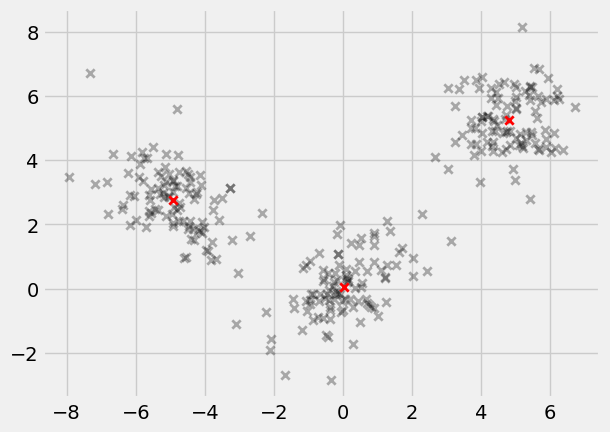

In [30]:
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

generator = np.random.default_rng(1_337)

# Generate data
desc = [
    (
        np.array([0.0, 0.0]),
        np.array(
            [
                [1.0, 0.5],
                [0.5, 1.0],
            ]
        ),
        100,
    ),
    (
        np.array([5.0, 5.0]),
        np.array(
            [
                [1.0, 0.0],
                [0.0, 1.0],
            ]
        ),
        100,
    ),
    (
        np.array([-5.0, 3.0]),
        np.array(
            [
                [1.0, -0.5],
                [-0.5, 1.0],
            ]
        ),
        100,
    ),
]
X = np.concatenate(
    [
        generator.multivariate_normal(mean=mean, cov=cov, size=(n,))
        for mean, cov, n in desc
    ],
    axis=0,
)

# Run k-means
result = k_means(data=X, n_clusters=len(desc), generator=generator)
print(f"Converged in {result.n_iters} iterations")

# Plot
plt.scatter(X[:, 0], X[:, 1], color="black", linewidth=2, marker="x", alpha=0.3)
plt.scatter(result.centroids[:, 0], result.centroids[:, 1], color="red", linewidth=2, marker="x")
plt.show()